# Data Preparation

In [1]:
import os
import zipfile
import cv2 as cv
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input

In [3]:
with zipfile.ZipFile("animals10.zip","r") as zip_ref:
    zip_ref.extractall("/content/")

In [5]:
#renaming folder
italian = ["cane","cavallo","elefante","farfalla","gallina","gatto","mucca","pecora","ragno","scoiattolo"]
english = ["dog","horse","elephant","butterfly","hen","cat","cow","sheep","spider","squirrel"]

for it,eng in zip(italian,english):
  os.rename(f"/content/raw-img/{it}", f"/content/raw-img/{eng}")

In [6]:
import splitfolders
splitfolders.ratio('/content/raw-img', output='/content/splitted', ratio=(.8, .2))

Copying files: 26179 files [00:06, 3844.46 files/s]


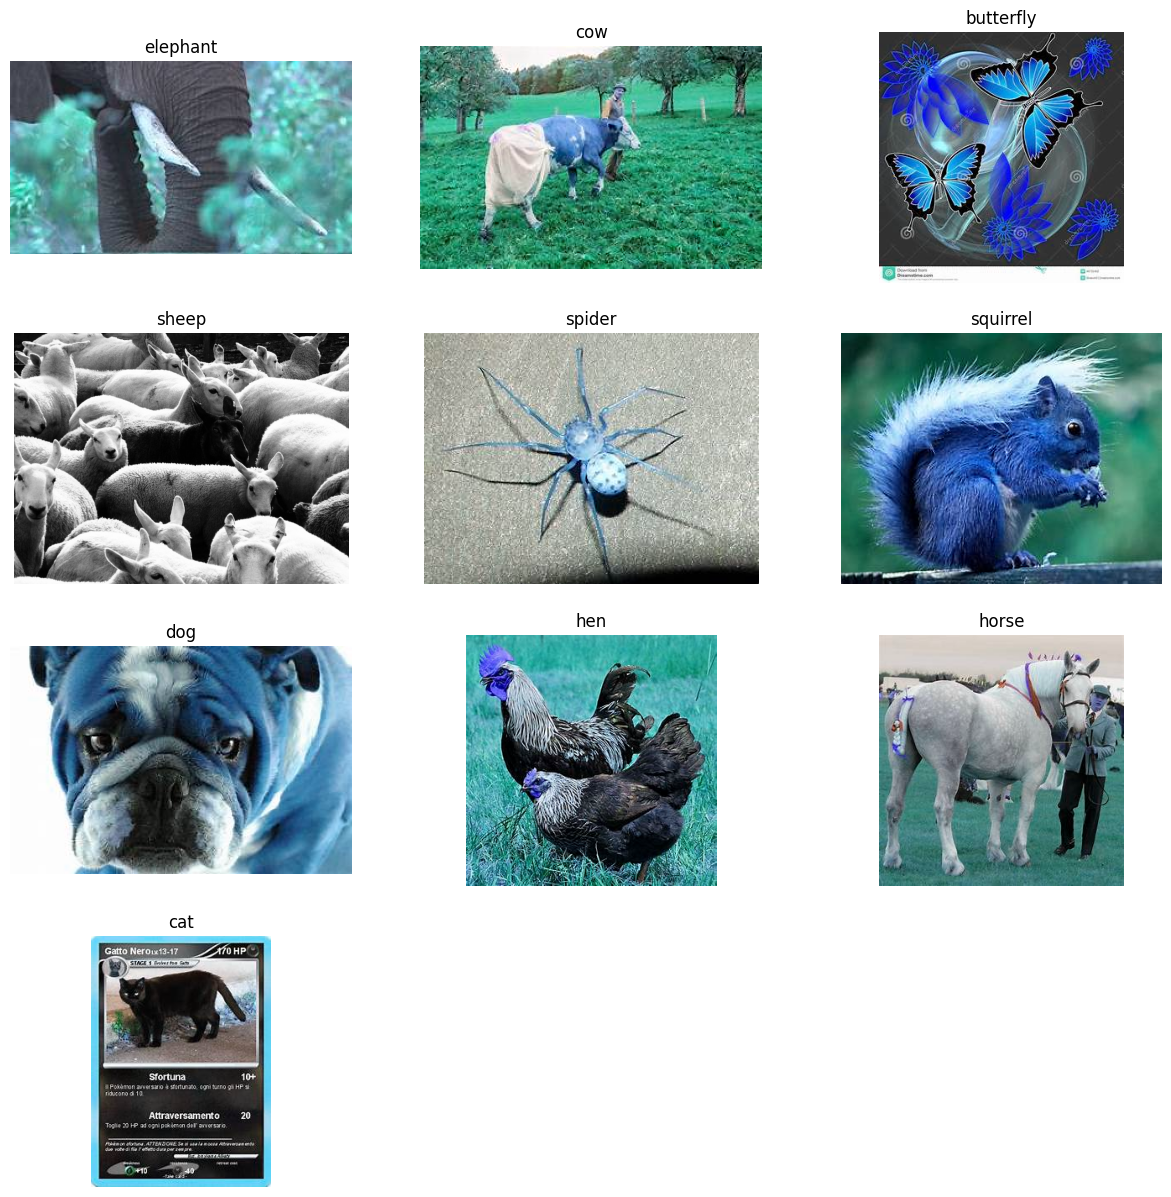

In [7]:
fig = plt.figure(figsize=(15,15))

image_folder = "/content/raw-img"
for index, label in enumerate(os.listdir(image_folder)):
  img = os.listdir(image_folder+"/"+label)[0]
  img = cv.imread(image_folder+"/"+label+"/"+img)

  fig.add_subplot(4, 3, index+1)
  plt.imshow(img)
  plt.title(label)
  plt.axis("off")
plt.show()


In [8]:
train_data = os.path.join("/content/splitted/train")
val_data = os.path.join("/content/splitted/val")

In [9]:
train_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)



In [10]:
train_generator = train_datagen.flow_from_directory(train_data,
                                                    target_size=(160, 160),
                                                    batch_size=30,
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(val_data,
                                                        target_size=(160, 160),
                                                        batch_size=30,
                                                        color_mode='rgb',
                                                        shuffle=True,
                                                        class_mode='categorical')

Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


# Buat Model
freezed MobileNetV2 + trainable output layer

In [11]:
IMG_SHAPE = (160,160,3)
LABELS = len(os.listdir(image_folder))

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
output_layer = Dense(LABELS, activation='softmax')

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 2236682 (8.53 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


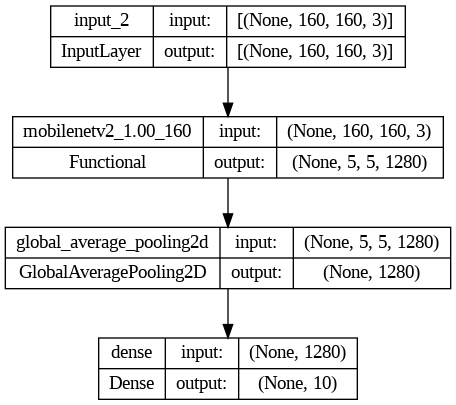

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Hyperparameter & Training

In [15]:
# Callback

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='animal_classification.h5', save_best_only=True)

my_callbacks = [
    earlystopping_callback,
    checkpoint_callback
]

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [17]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=my_callbacks)

Epoch 1/100
698/698 [==============================] - ETA: 0s - loss: 0.3356 - categorical_accuracy: 0.8916

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


698/698 [==============================] - 110s 105ms/step - loss: 0.3356 - categorical_accuracy: 0.8916 - val_loss: 0.2192 - val_categorical_accuracy: 0.9279
Epoch 2/100
698/698 [==============================] - 71s 101ms/step - loss: 0.1731 - categorical_accuracy: 0.9455 - val_loss: 0.2188 - val_categorical_accuracy: 0.9347
Epoch 3/100
698/698 [==============================] - 70s 100ms/step - loss: 0.1168 - categorical_accuracy: 0.9634 - val_loss: 0.2360 - val_categorical_accuracy: 0.9254
Epoch 4/100
698/698 [==============================] - 76s 109ms/step - loss: 0.0923 - categorical_accuracy: 0.9706 - val_loss: 0.2117 - val_categorical_accuracy: 0.9376
Epoch 5/100
698/698 [==============================] - 70s 100ms/step - loss: 0.0827 - categorical_accuracy: 0.9735 - val_loss: 0.2456 - val_categorical_accuracy: 0.9281
Epoch 6/100
698/698 [==============================] - 70s 101ms/step - loss: 0.0621 - categorical_accuracy: 0.9797 - val_loss: 0.2323 - val_categorical_accuracy

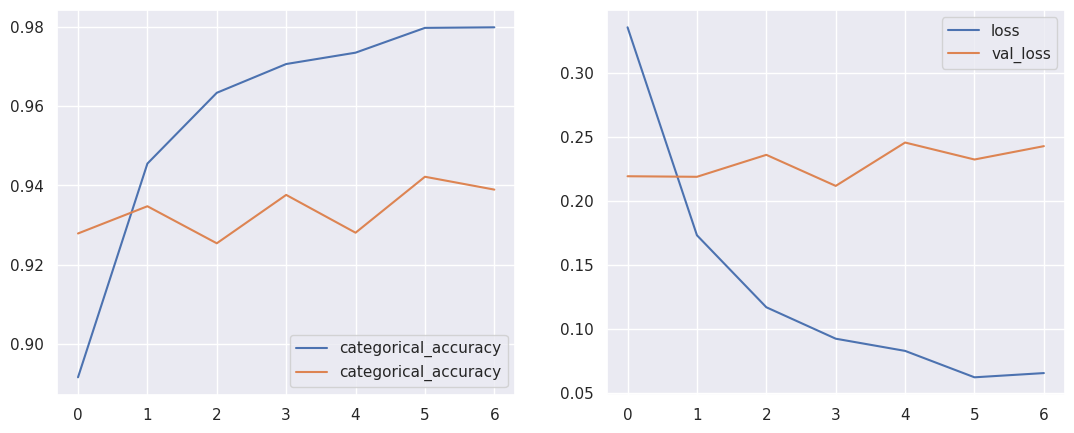

In [33]:
sns.set_theme(style='darkgrid')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,5))

sns.lineplot(history.history['categorical_accuracy'], label='categorical_accuracy', ax=ax1)
sns.lineplot(history.history['val_categorical_accuracy'], label='categorical_accuracy', ax=ax1)

sns.lineplot(history.history['loss'], label='loss', ax=ax2)
sns.lineplot(history.history['val_loss'], label='val_loss', ax=ax2)
plt.show()

# Coba Prediksi

In [14]:
model = tf.keras.models.load_model('animal.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 2236682 (8.53 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [36]:
path = 'tes.jpeg'
img = image.load_img(path, target_size=(160, 160))
img = image.img_to_array(img)
img = img.reshape((160, 160, 3))
img = img / 255.0  # Normalize pixel values
img = np.expand_dims(img, axis=0)

In [22]:
label = {0: 'butterfly', 1: 'cat', 2: 'cow', 3: 'dog', 4: 'elephant',
         5: 'hen', 6: 'horse', 7: 'sheep', 8: 'spider', 9: 'squirrel'}

In [31]:
logits = model.predict(img)
predicted = np.argmax(logits)
result = label[predicted]

1/1 [==============================] - 0s 69ms/step


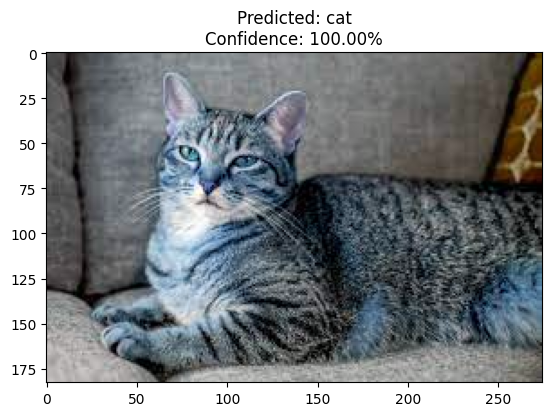

In [44]:
plt.imshow(cv.imread(path))
plt.title("Predicted: {}\nConfidence: {:.2f}%".format(result, logits[0][predicted]*100))
plt.show()